## Важно:

Пожалуйста, поддерживайте ваш код в хорошем состоянии, пишите комментарии, убирайте бесполезные ячейки, пишите модели в специально отведенных модулях. Проверяющие могут **НА СВОЕ УСМОТРЕНИЕ** снижать баллы за:

1. Говнокод
2. Неэффективные решения
3. Вермишель из ячеек в тетрадке
4. Все остальное что им не понравилось

## Важно 2 (0 - 0.3 балла):

За использование логгеров типа wandb/comet/neptune и красивую сборку этой домашки в виде графиков/картинок в этих логгерах мы будем выдавать бонусные баллы. 

## Важно 3:

Решением домашки является архив с использованными тетрадками/модулями, а так же **.pdf файл** с отчетом по проделанной работе по каждому пункту задачи. В нем необходимо описать какие эксперименты вы производили чтобы получить результат который вы получили, а так же обосновать почему вы решили использовать модели которые вы использовали (например denoising AE или sparce AE в пункте 1)




In [1]:
!pip install wandb -qq

In [2]:
!wandb login

wandb: Currently logged in as: lamalenny (use `wandb login --relogin` to force relogin)


In [3]:
import wandb
from wandb.lightgbm import wandb_callback

In [4]:
pip uninstall lightgbm

Uninstalling lightgbm-3.1.1:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/lightgbm-3.1.1-py3.7.egg-info
    /usr/local/lib/python3.7/dist-packages/lightgbm/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.7/dist-packages/lightgbm/lib_lightgbm.so
Proceed (y/n)? y
  Successfully uninstalled lightgbm-3.1.1


In [5]:
pip install lightgbm --install-option=--gpu --install-option="--opencl-include-dir=/usr/local/cuda/include/" --install-option="--opencl-library=/usr/local/cuda/lib64/libOpenCL.so"

/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py:283: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
  Using cached https://files.pythonhosted.org/packages/cf/65/368931f1f234149e14fc6075dbeb1ad8a8aebb105aa11fe8631c72c1bdcf/lightgbm-3.1.1.tar.gz
Skipping wheel build for lightgbm, due to binaries being disabled for it.
    Running setup.py install for lightgbm ... done


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
cd 'drive/MyDrive/DeepGenerativeModels/homework/1-AE'

/content/drive/MyDrive/DeepGenerativeModels/homework/1-AE


In [8]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from tqdm.notebook import tqdm, trange


import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload

In [9]:
% autoreload
from autoencoder import DummyAutoEncoder, DenoisingAutoEncoder
from classifier import Classifier
from run import run, get_latent_loader, get_latent_data

В этом домашнем задании мы будем автоэнкодить Omniglot. Omniglot - это датасет в основном для few-shot learning'а, состоящий из рукописных символов из разных существующих и несуществующих (эльфийский, клингонский) языков.

В этом датасете очень много классов, для для каждого класса представлено только 10-20 картинок. Если учить честную классификацию, мы быстро столкнемся с тем, что модель не сможет нормально выучиться.

В этой тетрадке вам предлагается попробовать решить эту проблему - выучить автоэнкодер (любой формы) и, используя латентное его представление, делать классификацию более сложными методами на меньше размерности.

Omniglot очень странно построен, в нем background - это единицы, а не нули. Чтобы перевести это в удобный для нас формат - инвертируем каждый пиксель через нашу кастомную трансформацию - InvertImage


In [10]:
class InvertImage:
    def __call__(self, pic):
        return 1 - pic

    def __repr__(self):
        return self.__class__.__name__ + '()'


In [11]:
from omniglot import FullOmniglot
from torchvision import transforms

from torch.utils.data import DataLoader, Subset, TensorDataset

from sklearn.model_selection import train_test_split

data_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    InvertImage()
    #transforms.Normalize([0.5], [0.5])
])

cuda_num = 0
device = f'cuda:{cuda_num}' if torch.cuda.is_available() else 'cpu'
batch_size = 64

Мы используем кастомный датасет FullOmniglot потому что изначально train/val части омниглота использую разные классы. Мы обьединяем их и делаем свое разбиение

In [12]:
full_dataset = FullOmniglot('./Omniglot', transform=data_transforms, download=True)

labels = []
for _, label in full_dataset:
    labels.append(label)
    
# делаем так, чтобы сплит был сбалансированным по классам
indices_train, indices_test, _, _ = train_test_split(list(range(len(labels))), labels, test_size=0.1, stratify=labels, random_state=42)

train_dataset = Subset(full_dataset, indices=indices_train)
test_dataset = Subset(full_dataset, indices=indices_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, drop_last=True)


Files already downloaded and verified
Files already downloaded and verified


In [13]:
def process_image(image):
    return (image.squeeze().detach().to('cpu') + 1) / 2

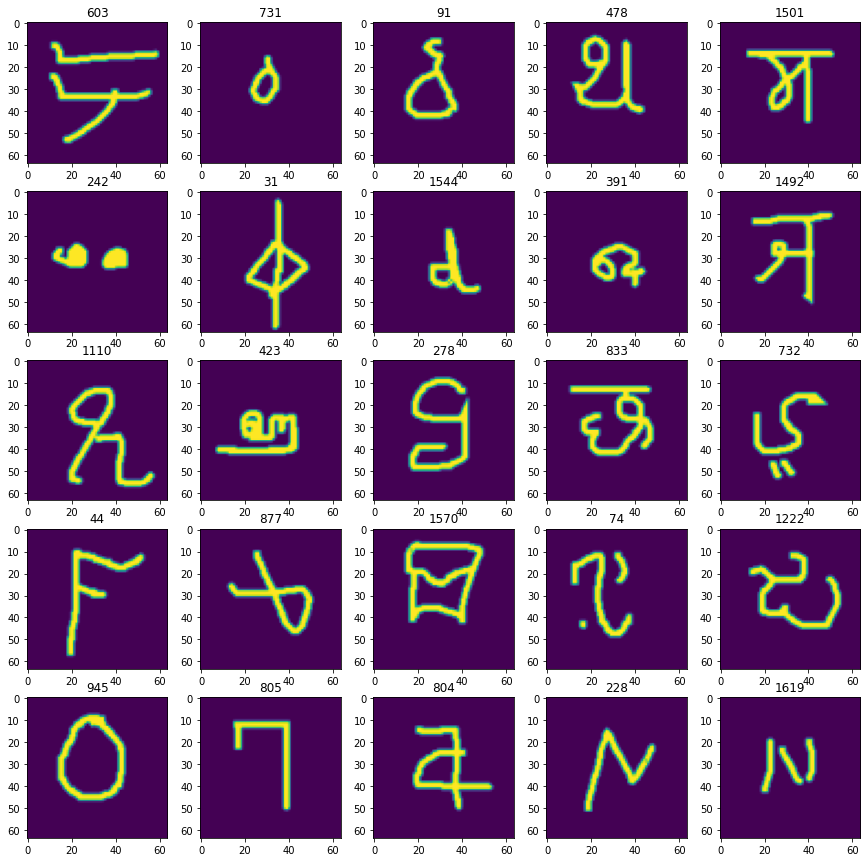

In [14]:
test_batch = next(iter(train_loader))


plt.figure(figsize=(15, 15))
for ind, (image, label) in enumerate(zip(*test_batch)):
    if ind >= 25: break
    plt.subplot(5, 5, ind+1)
    plt.imshow(process_image(image))
    plt.title(label.item())
plt.show()
    

### Задача 1 (0.3 балла):

Написать свой автоэнкодер, доучить его до приличного качества

Для того чтобы писать красивый код и не делать тетрадку слишком длинной предлагается писать свои модели в отдельном модуле, см `./autoencoder.py`

Простой автоэнкодер

In [ ]:
ae = DummyAutoEncoder().to(device)

wandb: Currently logged in as: lamalenny (use `wandb login --relogin` to force relogin)


Epoch,19
Train Loss,0.04903
_runtime,1396
_timestamp,1614377113
_step,9121


Epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
Train Loss,█▅▃▃▂▂▃▂▂▂▃▂▂▂▂▂▁▂▂▁▁▁▁▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


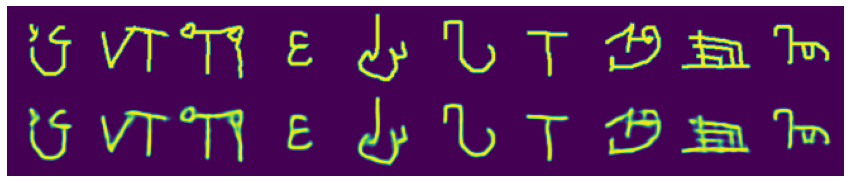

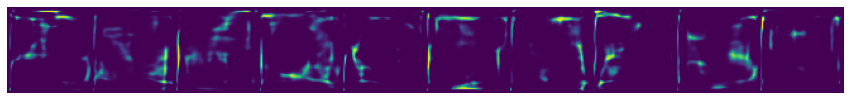

In [ ]:
run(ae, 20, train_loader, test_loader, 'AE_dummy', mode='ae', sparse_ae=False)

Denoising автоэнкодер

In [ ]:
ae = DenoisingAutoEncoder().to(device)

Epoch,19
Train Loss,0.10285
_runtime,4235
_timestamp,1614383372
_step,9121


Epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
Train Loss,█▆▄▄▃▄▄▃▂▃▄▂▃▃▃▄▂▃▃▂▁▂▂▂▃▂▃▃▂▂▂▁▂▂▁▂▂▁▂▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


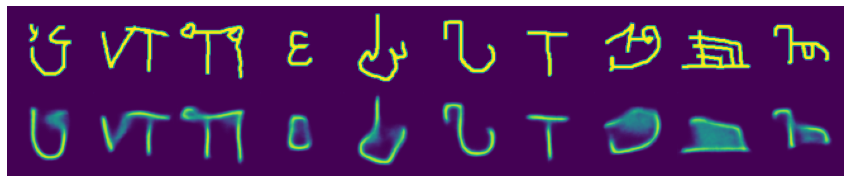

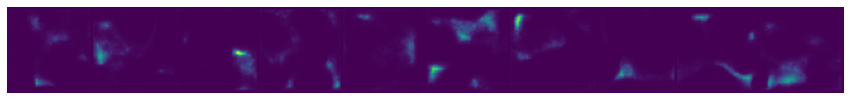

In [ ]:
run(ae, 20, train_loader, test_loader, 'AE_denoising', mode='ae', sparse_ae=False)

Sparse автоэнкодер (с l1 регуляризацией)

In [ ]:
ae = DummyAutoEncoder().to(device)

Epoch,19
Train Loss,0.05886
_runtime,1428
_timestamp,1614378577
_step,9121


Epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
Train Loss,█▅▄▃▃▃▃▂▂▂▃▂▂▂▂▂▂▂▂▁▁▁▁▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


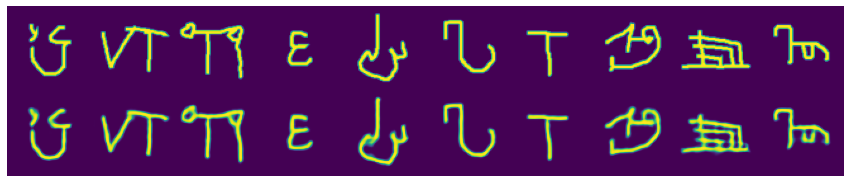

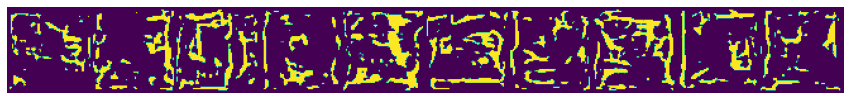

In [ ]:
run(ae, 20, train_loader, test_loader, 'AE_sparse', mode='ae', sparse_ae=True)

Мало посмотреть на результаты глазами, надо еще посчитать метрики качества.

Для этой задачи не очень хочется использовать FID с Inception обученными на ImageNet'е, поэтому предлагается обучить свою модель классификации на MNIST

Это можно сделать здесь (только красиво) или вынести в отдельную тетрадку/файлы

### Задача 2 (0.3 балла):

Научить внешний классификатор классифицировать MNIST, использовать его в подсчете FID между реальным Omniglot и выходами автоэнкодера

##### Классификация MNIST

In [ ]:
from torchvision.datasets import MNIST

mnist_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    #transforms.Normalize([0.5], [0.5])
])

mnist_dataset = MNIST('./MNIST', train=True, transform=data_transforms, download=True)
mnist_loader = DataLoader(mnist_dataset, batch_size=batch_size, drop_last=True, shuffle=True)

In [ ]:
mnist_test_dataset = MNIST('./MNIST', train=False, transform=data_transforms, download=True)
mnist_test_loader = DataLoader(mnist_test_dataset, batch_size=batch_size, drop_last=False, shuffle=False)

In [ ]:
%autoreload
from classifier import Classifier

In [ ]:
clf = Classifier(n_classes=10).to(device)

In [ ]:
run(clf, n_epochs=15, train_loader=mnist_loader, test_loader=mnist_test_loader, 
    name='CNN_mnist', mode='clf')

wandb: Currently logged in as: lamalenny (use `wandb login --relogin` to force relogin)


Epoch,14
Train Loss,0.06844
_runtime,321
_timestamp,1614422593
_step,14055
Test accuracy,0.9874


Epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
Train Loss,▇▃▃▃▂▂█▄▁█▁▃▃▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▃▂▂▄▁▄▁▁▁▂▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Test accuracy,▁


Получился скор 0.9874

##### FID

Загрузим обученные модели

In [21]:
ae_dummy = DummyAutoEncoder().to(device)
ae_denoising = DenoisingAutoEncoder().to(device)
ae_sparse = DummyAutoEncoder().to(device)
clf = Classifier().to(device)

checkpoint_dummy = torch.load('params/AE_dummy19.pt')
checkpoint_denoising = torch.load('params/AE_denoising19.pt')
checkpoint_sparse = torch.load('params/AE_sparse19.pt')
checkpoint_clf = torch.load('params/CNN_mnist14.pt')

ae_dummy.load_state_dict(checkpoint_dummy['model_state_dict'])
ae_denoising.load_state_dict(checkpoint_denoising['model_state_dict'])
ae_sparse.load_state_dict(checkpoint_sparse['model_state_dict'])
clf.load_state_dict(checkpoint_clf['model_state_dict'])

<All keys matched successfully>

In [22]:
class NoiseRecoModel(nn.Module):
    def __init__(self, intensivity=0.1):
        super().__init__()
        # self.placeholder_layer
        # ненужный слой, который позвоняет в calculate_fid смотреть на каком девайсе расположена сетка
        self.placeholder_layer = nn.Linear(1, 1)
        self.intensivity = intensivity
        
    def forward(self, x):
        # немного поправила выход, 
        # тк моя модель возвращает кортеж из выхода со слоя и l1_loss (или 0.)
        return (x + torch.rand_like(x) * self.intensivity), 0.

Проверим насколько наша метрика стабильна: чем больше шум, тем больше она должна становиться

In [29]:
from calculate_fid import calculate_fid

session = wandb.init(name='FID', 
                 project='gen_models_hw1', 
                 tags=['ae', 'clf', str(device)])

wandb.log({'FID_dummy': calculate_fid(test_loader, ae_dummy, clf), 
           'FID_denoising': calculate_fid(test_loader, ae_denoising, clf), 
           'FID_sparse': calculate_fid(test_loader, ae_sparse, clf)})

for noise_level in [0.001, 0.01, 0.05, 0.1, 0.5, 0.7, 1.]:
    noise_model = NoiseRecoModel(noise_level).to(device)
    wandb.log({f'FID_noise_{noise_level}': 
               calculate_fid(test_loader, noise_model, clf)})
session.finish()

FID_dummy,2.13224
FID_denoising,46.94127
FID_sparse,2.8985
_runtime,80
_timestamp,1614458200
_step,7
FID_noise_0.001,0.00066
FID_noise_0.01,0.09482
FID_noise_0.05,2.92264
FID_noise_0.1,14.98887
FID_noise_0.5,577.31681


FID_dummy,▁
FID_denoising,▁
FID_sparse,▁
_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
FID_noise_0.001,▁
FID_noise_0.01,▁
FID_noise_0.05,▁
FID_noise_0.1,▁
FID_noise_0.5,▁


Мы предлагаем использовать латентные фичи из AE для классификации.

Главная проблема классификации на Omniglot в том, что классов очень много и обычные классификаторы не могут справиться:

### Задача 3 (0.2 балла):

Попробовать честную классификацию на Omniglot, довести ее до приличного качества.

In [ ]:
clf = Classifier(n_classes=1623).to(device)

In [ ]:
run(clf, n_epochs=30, train_loader=train_loader, test_loader=test_loader, 
    name='CNN_omniglot', mode='clf')

Epoch,29
Train Loss,0.04712
_runtime,1489
_timestamp,1614385002
_step,13680
Test accuracy,0.62562


Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
Train Loss,█▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Test accuracy,▁


Посчитаем аккураси:

У классификатора получилось accuracy 0.62562 (см. run summary).

In [ ]:
print(f"random accuracy: {1/1623}")

random accuracy: 0.0006161429451632779


Возможное решение проблемы с классификацией - обработка данный автоэнкодером и использование преобразованных латентных фичей вместо картинок.

Латентные фичи можно представить в виде табличных 1D данных, на которых можно учить даже разные бустинги.


### Задача 4 (0.2 балла):

Получить латентные представления от картинок в Omniglot, выучить любую (хорошую) модель классификации на них до адекватного качества.

note: не забывайте учить на трейне, а считать аккураси на тесте

In [15]:
ae_dummy = DummyAutoEncoder().to(device)
ae_sparse = DummyAutoEncoder().to(device)

checkpoint_dummy = torch.load('params/AE_dummy19.pt')
checkpoint_sparse = torch.load('params/AE_sparse19.pt')

ae_dummy.load_state_dict(checkpoint_dummy['model_state_dict'])
ae_sparse.load_state_dict(checkpoint_sparse['model_state_dict'])

<All keys matched successfully>

In [16]:
from sklearn.metrics import accuracy_score

#### Sparse

##### MLP

In [ ]:
%autoreload
from classifier import MLP

In [ ]:
train_latent_loader = get_latent_loader(ae_sparse, train_loader, 64, True)
test_latent_loader = get_latent_loader(ae_sparse, test_loader, 64, False)

In [ ]:
mlp = MLP(512, 1623)

In [ ]:
run(mlp, n_epochs=100, train_loader=train_latent_loader, test_loader=test_latent_loader, 
    name='MLP_sparse', mode='clf')

Epoch,99
Train Loss,0.03595
_runtime,1530
_timestamp,1614435425
_step,45600
Test accuracy,0.53375


Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Train Loss,█▆▅▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇██
_timestamp,▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Test accuracy,▁


##### Gradient Boosting

In [17]:
import lightgbm as lgb

In [18]:
X_train, y_train = get_latent_data(ae_sparse, train_loader, train=True)
X_test, y_test = get_latent_data(ae_sparse, test_loader, train=False)

In [19]:
params = {"objective": "multiclass",
          "num_class": 1623,
          "device_type": "gpu", 
          "learning_rate": 1e-2, 
          "max_depth": 5, 
          "num_leaves" : 2 ** 5, 
          "seed": 42, 
          "nthread": 35, 
          "verbosity": -1, 
          'num_rounds': 50}

In [20]:
run = wandb.init(name='GB_sparse', 
                 project='gen_models_hw1', 
                 tags=['clf', str(device)])

wandb: Currently logged in as: lamalenny (use `wandb login --relogin` to force relogin)


In [21]:
lgbtrain = lgb.Dataset(X_train.numpy(), y_train.numpy())
lgbtest = lgb.Dataset(X_test.numpy(), y_test.numpy())

In [22]:
gbm = lgb.train(params, 
                lgbtrain, 
                valid_sets = [lgbtrain, lgbtest], 
                verbose_eval=1,
                callbacks=[wandb_callback()])

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:151: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's multi_logloss: 5.60408	valid_1's multi_logloss: 7.10436
[2]	training's multi_logloss: 4.64423	valid_1's multi_logloss: 7.02088
[3]	training's multi_logloss: 4.03762	valid_1's multi_logloss: 6.97904
[4]	training's multi_logloss: 3.60482	valid_1's multi_logloss: 6.9393
[5]	training's multi_logloss: 3.2921	valid_1's multi_logloss: 6.90334
[6]	training's multi_logloss: 3.05084	valid_1's multi_logloss: 6.87295
[7]	training's multi_logloss: 2.85587	valid_1's multi_logloss: 6.84725
[8]	training's multi_logloss: 2.69255	valid_1's multi_logloss: 6.82368
[9]	training's multi_logloss: 2.55429	valid_1's multi_logloss: 6.79981
[10]	training's multi_logloss: 2.43397	valid_1's multi_logloss: 6.77922
[11]	training's multi_logloss: 2.32754	valid_1's multi_logloss: 6.7586
[12]	training's multi_logloss: 2.23278	valid_1's multi_logloss: 6.74037
[13]	training's multi_logloss: 2.14715	valid_1's multi_logloss: 6.72216
[14]	training's multi_logloss: 2.0691	valid_1's multi_logloss: 6.70606
[15]	

In [23]:
y_pred = np.argmax(gbm.predict(X_test), axis=1)
acc = accuracy_score(y_pred, y_test)
wandb.log({"Test accuracy": acc})

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:597: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


In [24]:
run.finish()

training_multi_logloss,0.84955
valid_1_multi_logloss,6.32547
_runtime,6277
_timestamp,1614498314
_step,50
Test accuracy,0.10281


training_multi_logloss,█▇▆▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
valid_1_multi_logloss,█▇▇▇▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Test accuracy,▁


#### Simple AE

##### MLP

In [42]:
from classifier import MLP

In [45]:
train_latent_loader = get_latent_loader(ae_dummy, train_loader, 64, True)
test_latent_loader = get_latent_loader(ae_dummy, test_loader, 64, False)

In [46]:
mlp = MLP(512, 1623).to(device)
run(mlp, n_epochs=100, train_loader=train_latent_loader, test_loader=test_latent_loader, 
    name='MLP_dummy', mode='clf')

Epoch,99
Train Loss,0.45493
_runtime,267
_timestamp,1614460099
_step,45600
Test accuracy,0.53656


Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Train Loss,█▄▃▂▁▂▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Test accuracy,▁


##### GB

In [25]:
import lightgbm as lgb

In [26]:
X_train, y_train = get_latent_data(ae_dummy, train_loader, train=True)
X_test, y_test = get_latent_data(ae_dummy, test_loader, train=False)

In [27]:
params = {"objective": "multiclass",
          "num_class": 1623,
          "device_type": "gpu", 
          "learning_rate": 1e-2, 
          "max_depth": 5, 
          "num_leaves" : 2 ** 5, 
          "seed": 42, 
          "nthread": 35, 
          "verbosity": -1, 
          'num_rounds': 50}

In [28]:
run = wandb.init(name='GB_dummy', 
                 project='gen_models_hw1', 
                 tags=['clf', str(device)])

In [29]:
lgbtrain = lgb.Dataset(X_train.numpy(), y_train.numpy())
lgbtest = lgb.Dataset(X_test.numpy(), y_test.numpy())

In [30]:
gbm = lgb.train(params, 
                lgbtrain, 
                valid_sets = [lgbtrain, lgbtest], 
                verbose_eval=1,
                callbacks=[wandb_callback()])

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:151: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's multi_logloss: 5.4534	valid_1's multi_logloss: 7.03994
[2]	training's multi_logloss: 4.50135	valid_1's multi_logloss: 6.93987
[3]	training's multi_logloss: 3.90901	valid_1's multi_logloss: 6.88522
[4]	training's multi_logloss: 3.5026	valid_1's multi_logloss: 6.84027
[5]	training's multi_logloss: 3.2034	valid_1's multi_logloss: 6.80466
[6]	training's multi_logloss: 2.97502	valid_1's multi_logloss: 6.77016
[7]	training's multi_logloss: 2.78928	valid_1's multi_logloss: 6.74086
[8]	training's multi_logloss: 2.6338	valid_1's multi_logloss: 6.71268
[9]	training's multi_logloss: 2.50165	valid_1's multi_logloss: 6.68869
[10]	training's multi_logloss: 2.38672	valid_1's multi_logloss: 6.66553
[11]	training's multi_logloss: 2.28498	valid_1's multi_logloss: 6.64533
[12]	training's multi_logloss: 2.19352	valid_1's multi_logloss: 6.62475
[13]	training's multi_logloss: 2.11017	valid_1's multi_logloss: 6.60438
[14]	training's multi_logloss: 2.0337	valid_1's multi_logloss: 6.58604
[15]	t

In [31]:
y_pred = np.argmax(gbm.predict(X_test), axis=1)
acc = accuracy_score(y_pred, y_test)
wandb.log({"Test accuracy": acc})

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:597: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


In [32]:
run.finish()

training_multi_logloss,0.83435
valid_1_multi_logloss,6.17024
_runtime,6230
_timestamp,1614504631
_step,50
Test accuracy,0.11375


training_multi_logloss,█▇▆▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
valid_1_multi_logloss,█▇▇▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Test accuracy,▁
